<a href="https://colab.research.google.com/github/murilo-henrique060/matematica-computacional/blob/main/Atividade%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atividade 2 - Gradiente Descendente, Regresão Linear, Redes Neurais e Backpropagation

## Módulo de Desenho

Para representar visualmente os treinamentos vamos criar alguns utilitários para abstrair a complexidade e melhorar a compreensão do código.

Para isso, vamos criar algumas classes:
- `Plot`: Classe para gerenciar configurações do gráfico
- `PlotObject`: Classe base para todos os objetos desenhados no gráfico
  * `PointObject`: Desenha um ponto no gráfico
  * `LineObject`: Desenha uma linha a partir de 2 pontos no gráfico
  * `FunctionObject`: Desenha uma linha/curva a partir de uma função $y = f(x)$ no gráfico
  * `LineFunctionObject`: Desenha uma linha a partir de uma funcão linear $y = f(x)$ no gráfico

In [ ]:
from IPython.display import HTML

import itertools, math, random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [ ]:
class Plot():
  def __init__(self, grid=(1, 1), figsize=(4, 4), axis=(0, 4, 0, 4), title=""):
    self.fig, self.ax = plt.subplots(grid[0], grid[1], figsize=figsize)
    self._updated = []

    if grid[0] == 1 and grid[1] == 1:
      self.ax._plot = self
      self.ax.grid(True)
      self.ax.set_xlim(axis[0], axis[1])
      self.ax.set_ylim(axis[2], axis[3])

      if title != "":
        self.ax.set_title(title)

      return

    for index, ax in enumerate(self.ax):
      ax._plot = self
      ax.grid(True)
      ax.set_xlim(axis[index][0], axis[index][1])
      ax.set_ylim(axis[index][2], axis[index][3])

      if len(title) > index and isinstance(title[index], str):
        ax.set_title(title[index])

  @property
  def updated(self):
    updated = self._updated
    self._updated = []
    return updated

  def show(self):
    plt.show()

  def animate(self, update, frames=100, blit=True, interval=100, **kwargs):
    plt.close()
    self._updated.clear()
    self.ani = animation.FuncAnimation(self.fig, update, frames=frames, blit=blit, interval=interval, **kwargs)
    return HTML(self.ani.to_html5_video())

In [ ]:
class PlotObject():
  def __init__(self, ax, points, zorder=1, **kwargs):
    self.ax = ax
    self.line, = ax.plot((), (), zorder=zorder+1000, **kwargs)
    self.points = points

  @property
  def points(self):
    return np.array(list(zip(*self.line.get_data())))

  @points.setter
  def points(self, points):
    if len(points) == 0:
      self.line.set_data((), ())
    else:
      self.line.set_data(*zip(*points))

    if (self.line not in self.ax._plot._updated):
      self.ax._plot._updated.append(self.line)

In [ ]:
class PointObject(PlotObject):
  @staticmethod
  def factory(ax, points, **kwargs):
    return [PointObject(ax, point, **kwargs) for point in points]

  def __init__(self, ax, point, color='green', marker='o', **kwargs):
    super().__init__(ax, [point], color=color, marker=marker, **kwargs)

  @property
  def point(self):
    return self.points[0]

  @point.setter
  def point(self, point):
    self.points = [point]

  @property
  def x(self):
    return self.point[0]

  @x.setter
  def x(self, x):
    self.point = (x, self.point[1])

  @property
  def y(self):
    return self.point[1]

  @y.setter
  def y(self, y):
    self.point = (self.point[0], y)

In [ ]:
class LineObject(PlotObject):
  @staticmethod
  def factory(ax, lines, **kwargs):
    return [LineObject(ax, *line, **kwargs) for line in lines]

  def __init__(self, ax, start, end, color='gray', **kwargs):
    super().__init__(ax, [start, end], color=color, **kwargs)

  @property
  def start(self):
    return self.points[0]

  @start.setter
  def start(self, start):
    self.points = [start, self.points[1]]

  @property
  def end(self):
    return self.points[1]

  @end.setter
  def end(self, end):
    self.points = [self.points[0], end]

In [ ]:
class FunctionObject(PlotObject):
  def __init__(self, ax, function=lambda x: x, samples=100, color='blue', **kwargs):
    self._function = function
    self._samples = samples
    super().__init__(ax, [], color=color, **kwargs)

    self.update_path()

  def update_path(self):
    xlimits = self.ax.get_xlim()
    self.xpoints = np.linspace(xlimits[0], xlimits[1], self._samples)
    self.line.set_data(self.xpoints, list(map(self._function, self.xpoints)))

  @property
  def function(self):
    return self._function

  @function.setter
  def function(self, function):
    self._function = function
    self.update_path()

  @property
  def samples(self):
    return self._samples

  @samples.setter
  def samples(self, samples):
    self._samples = samples
    self.update_path()

In [ ]:
class LineFunctionObject(FunctionObject):
  def __init__(self, plot, function=lambda x: x, **kwargs):
    super().__init__(plot, function, samples=2, **kwargs)

## Regressão Linear

Regressão linear é um processo utilizado para prever tendências de dados. Então, para começar, precisamos de dados:

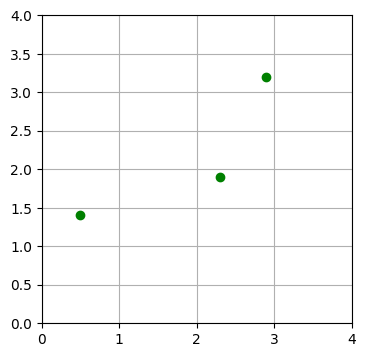

In [ ]:
DATA = [(0.5, 1.4), (2.3, 1.9), (2.9, 3.2)]

plot = Plot()
PointObject.factory(plot.ax, DATA)
plot.show()

## Função Predict (p)

Os dados são representados por pontos $(x, y)$, e o conjunto de dos dados é um função $f(x)$ que está definida apenas nos pontos $x \in \{0.5, 2.3, 2.9\}$

Porém queremos uma funcão contínua $p(x)$ tal que $p(x) ≈ f(x)$, ou seja, que prevê o resultado da função $f$, até para valores fora de seu domínio.*texto em itálico*

## Slope e Intercept

Digamos que podemos aproximar $f$ com uma função linear, nesse caso a função $p$ teria o formato:

$$
p(x) = ax + b
$$

> OBS1: sabemos que não conseguiremos um resultado exato, pois os pontos não estão em linha reta, mas para um caso em que não precisamos de uma precisão tão alta uma função linear é suficiente

Onde $a$ é o coeficiente angular e $b$ o coeficiente linear, mas para melhor compreensão podemos mudar o nome dessas variáveis baseado na forma como elas modificam a reta, então agora representaremos $p(x)$ como:

$$
p(x) = \text{slope} \cdot x + \text{intercept}
$$

Onde:
  - $\text{slope}$: coeficiente angular de $p$, é responsável por ajustar o ângulo da reta;
  - $\text{intercept}$: coeficiente linear da $p$, é responsável por ajustar a posição vertical da reta;

In [ ]:
plot = Plot(grid=(1, 2), figsize=(8, 4), axis=[(0, 4, 0, 4), (0, 4, 0, 4)], title=("Variando o slope", "Variando o intercept"))
line_slope = LineFunctionObject(plot.ax[0], color='lightblue')
line_intercept = LineFunctionObject(plot.ax[1], color='lightblue')

def update(frame):
  line_slope.function = lambda x: frame * x + 0 # Variando o slope da reta 0
  line_intercept.function = lambda x: 1 * x + frame # Variando o intercept da reta 1
  return plot.updated

plot.animate(update, frames=np.linspace(0, 2, 100))

## Observed e Predicted

As funções $f(x)$ e $p(x)$ podem ser nomeadas em relação a sua funcionalidade:
- Observed: $f(x)$, representa o valor real que queremos adivinhar;
- Predicted: $p(x)$, representa o valor que estamos prevendo.

## Error

Como $\text{Predicted} ≈ \text{Observed}$, temos que $\text{Error} = \text{Observed} - \text{Predicted}$, onde $\text{Error}$ é o erro de $\text{Predicted}$.

Para que $\text{Predicted}$ peveja os valores corretamente temos que diminuir o $\text{Error}$ para o menor valor possível.

Mas como $\text{Error}$ é linear, um programa para encontrar o mínimo iterativamente teria que solucionar problemas como: dar passos maiores quando está mais longe do objetivo e menores quando está mais perto, além de passos para direita ou para a esquerda.

Então, para facilitar esse processo, utilizaremos o $\text{Error}^2$ ou $(\text{Observed} - \text{Predicted})^2$.

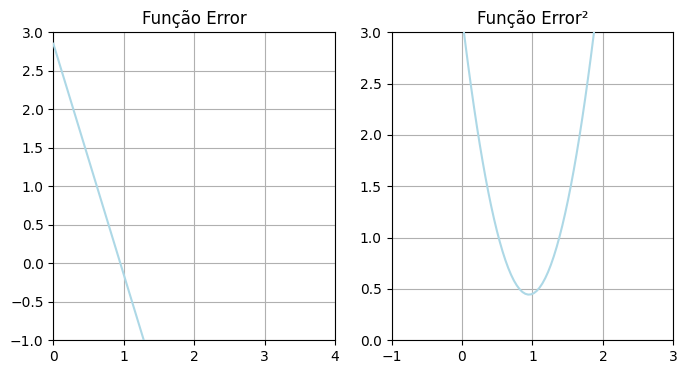

In [ ]:
plot = Plot(grid=(1, 2), figsize=(8,4), axis=((0, 4, -1, 3), (-1, 3, 0, 3)), title=("Função Error", "Função Error²"))
p = lambda x, b: 0.64 * x + b

error = lambda b: sum(x[1] - p(x[0], b) for x in DATA)
error_sqrd = lambda b: sum((x[1] - p(x[0], b))**2 for x in DATA)

FunctionObject(plot.ax[0], error, color='lightblue')
FunctionObject(plot.ax[1], error_sqrd, color='lightblue')
plot.show()

## Loss - Intercept

Digamos que o valor de $\text{slope}$ esteja otimizado ($0.64$), para otimizar apenas o $\text{intercept}$, devemos calcular o quanto a o parâmetro está longe do mínimo, e para isso utilizamos a derivada do $\text{Error}^2$ em função do $\text{intercept}$, que chamaremos de $\text{Loss}$:

$$
  \text{Loss} = \frac{d}{\text{d intercept}} \text{Error}^2 = -2 (\text{Observed} - (x \cdot \text{slope} + \text{intercept}))
$$

## Step

$\text{Loss}$ nos diz para qual direção e o quanto ir para o próxima tentativa no método iterativo, mas ainda precisamos ajustar a escala de quanto estamos indo para evitar que passemos do objetivo (overshoot).

Para isso definimos um parâmetro $\text{learning_rate}$, que controla a escala dos passos.

Então, o $\text{Step}$ (passo) é dado por:

$$
\text{Step} = \text{Loss} \cdot \text{learning_rate}
$$

## New Intercept

Para calcular o próximo chute subtraímos o $\text{Step}$ do $\text{intercept}$, chamaremos ele de $\text{new intercept}$


$$
\text{new_intercept} = \text{intercept} - \text{loss}
$$

## Regressão Linear - Intercept

O processo de Regressão Linear para o intercept consiste em:

1. Definir um chute inicial para o intercept (0 é um bom chute, já que 0 é o elemento neutro da soma)
2. Calcular o $\text{Loss}$
3. Calcular o $\text{Step}$
4. Calcular $\text{new_intercept}$
5. Se nenhum dos critérios de parada for cumprido, retornar ao passo 1
6. Senão, finalizar o algoritmo

## Critérios de parada - $\text{min_step_size}$

Como o $\text{Step}$ diminui de forma quadrática o quanto mais se aproxima no mínimo (derivada igual a 0), então podemos definir uma variável $\text{min_step_size}$ e um critério de parada $\text{Step} <= \text{min_step_size}$

## Critérios de parada - $\text{max_reps}$

Mesmo com o critério anterior, pode ocorrer que, mesmo depois de milhares de operações, ele ainda não tenha sido cumprido. Então definimos uma variável $\text{max_reps}$, que limita o número de iterações do algoritmo para que ele não rode iterações demais.

## Regressão Linear do Intercept - Código

A implementação da regressão linear consiste na seguinte classe:

```
LinearRegressionIntercept
  + slope
  + intercept

  + predict(x) // Método para prever os valores de f(x)
  + descent_gradient(data) // Método para calcular a soma do quadrado do erro e a sua derivada
  + learn(data, learn_rate, max_reps, min_step) // Método para implementar o algoritmo de treinamento
```

In [ ]:
class LinearRegressionIntercept():
  def __init__(self, slope=1, intercept=0):
    self.slope = slope
    self.intercept = intercept

  def predict(self, x, slope=None, intercept=None):
    if slope is None:
      slope = self.slope
    if intercept is None:
      intercept = self.intercept

    return slope * x + intercept

  def descent_gradient(self, data, **kwargs):
    residual_squared_sum = 0
    gradient = 0

    for x, y in data:
      diff = y - self.predict(x, **kwargs)
      residual_squared_sum += diff**2
      gradient += -2 * diff

    return residual_squared_sum, gradient

  def learn(self, data, learn_rate=0.1, max_reps=100, min_step=0.001, snapshots=False, verbose=False):
    for i in range(max_reps):
      residual_squared_sum, loss = self.descent_gradient(data)

      step = learn_rate * loss
      new_intercept = self.intercept - step

      if verbose:
        print(f"{'\r' if verbose != 'vv' else '\n'}iteration: {i+1:<5} step: {step:<25} intercept: {self.intercept:<25} new intercept: {new_intercept}", end="")

      if snapshots:
        yield self.intercept, residual_squared_sum, loss

      self.intercept = new_intercept

      if abs(step) <= min_step:
        break

    print()

## Regressão Linear do Intercept - Exemplo 1

visualização da regressão linear do dados mostrados:

In [ ]:
# Chute inicial para o intercept
linearRegression = LinearRegressionIntercept(slope=0.64, intercept=0)

# Iniciando Gráfico
plot = Plot(grid=(1, 2), figsize=(8, 4), axis=((0, 4, 0, 4), (-1, 3, 0, 8)), title=("Função Predicted", "Erro² em função do Intercept"))

# Desenhado elementos do gráfico à direita
PointObject.factory(plot.ax[0], DATA) # Desenhando os pontos
predicted = LineFunctionObject(plot.ax[0], color='lightblue') # Criando a linha da função predicted

# Desenhando elementos do gráfico à direita
FunctionObject(plot.ax[1], lambda x: linearRegression.descent_gradient(DATA, intercept=x)[0]) # Desenhando a linha da função Error²
error_grad = LineFunctionObject(plot.ax[1], color='green') # Criando a linha do gradiente de Error

# Função para atualizar cada quadro da animação
def update(frame_data):
  intercept, residual_squared_sum, loss = frame_data

  # Desenhando a linha da função predict
  predicted.function = lambda x: linearRegression.predict(x, intercept=intercept)

  # Desenhando o ponto representando o intercept atual
  PointObject(plot.ax[1], (intercept, residual_squared_sum), color='red')

  # Desenhando a linha do gradiente de Error
  error_grad.function = lambda x: loss * (x - intercept) + residual_squared_sum

  return plot.updated

# Obtendo dados de treinamento
learn_data = linearRegression.learn(DATA, learn_rate=0.01, max_reps=100, min_step=0.0001, snapshots=True, verbose=True) # Use verbose='vv' para mostrar o log completo
# Iniciando animação
plot.animate(update, frames=learn_data, save_count=100)


iteration: 100   step: -0.00012469154990496278   intercept: 0.9485884741682507        new intercept: 0.9487131657181556

## Regressão Linear do Intercept - Exemplo 2

Duas Regressões lineares com diferentes learn_rates

In [ ]:
# Chute inicial para o intercept
linearRegression0 = LinearRegressionIntercept(slope=0.64, intercept=0)
linearRegression1 = LinearRegressionIntercept(slope=0.64, intercept=0)

# Iniciando Gráfico
plot = Plot(grid=(1, 2), figsize=(8, 4), axis=((-1, 3, 0, 8), (-1, 3, 0, 8)), title=("Learning Rate = 0.1", "Learning Rate = 0.001"))

# Desenhando as linha da função Error²
FunctionObject(plot.ax[0], lambda x: linearRegression.descent_gradient(DATA, intercept=x)[0])
FunctionObject(plot.ax[1], lambda x: linearRegression.descent_gradient(DATA, intercept=x)[0])

# Criando as linhas dos Gradientes de Error
error_grad = (
    LineFunctionObject(plot.ax[0], color='green'),
    LineFunctionObject(plot.ax[1], color='green'),
)

# Função para atualizar cada quadro da animação
def update(frame_data):
  for i, data in enumerate(frame_data):
    if data is None:
      continue

    intercept, residual_squared_sum, loss = data

    # Desenhando o ponto representando o intercept atual
    PointObject(plot.ax[i], (intercept, residual_squared_sum), color='red')

    # Desenhando a linha do gradiente de Error
    error_grad[i].function = lambda x: loss * (x - intercept) + residual_squared_sum

  return plot.updated

# Obtendo dados de treinamento
learn_data_0 = linearRegression0.learn(DATA, learn_rate=0.1, max_reps=100, min_step=0.0001, snapshots=True, verbose='vv') # Use verbose='vv' para mostrar o log completo
learn_data_1 = linearRegression1.learn(DATA, learn_rate=0.01, max_reps=100, min_step=0.0001, snapshots=True, verbose='vv') # Use verbose='vv' para mostrar o log completo

# Iniciando animação
plot.animate(update, frames=itertools.zip_longest(learn_data_0, learn_data_1), save_count=500)



iteration: 1     step: -0.5704000000000001       intercept: 0                         new intercept: 0.5704000000000001
iteration: 1     step: -0.05704000000000001      intercept: 0                         new intercept: 0.05704000000000001
iteration: 2     step: -0.22815999999999992      intercept: 0.5704000000000001        new intercept: 0.79856
iteration: 2     step: -0.0536176                intercept: 0.05704000000000001       new intercept: 0.11065760000000001
iteration: 3     step: -0.09126399999999997      intercept: 0.79856                   new intercept: 0.8898240000000001
iteration: 3     step: -0.050400544000000005     intercept: 0.11065760000000001       new intercept: 0.16105814400000001
iteration: 4     step: -0.03650560000000005      intercept: 0.8898240000000001        new intercept: 0.9263296000000001
iteration: 4     step: -0.047376511360000005     intercept: 0.16105814400000001       new intercept: 0.20843465536000003
iteration: 5     step: -0.014602239999999968  

# Regressão Linear - Otimizando 2 parâmetros

Para otimizar o $\text{slope}$ temos que calcular o seu $\text{loss}$, $\text{step}$ e $\text{new_slope}$. Para isso podemos derivar o $\text{Error}^2$ em função do $\text{slope}$.

$$
\text{Loss}_{\text{slope}} = \frac{d}{\text{d slope}} \text{Error}^2 = (-2x) \cdot (\text{Observed} - (x \cdot \text{slope} + \text{intercept}))
$$

Assim temos que:

$$
\text{Step}_\text{slope} = \text{Loss}_\text{slope} \cdot \text{learning_rate}
$$

e:

$$
\text{new_slope} = \text{slope} - \text{Step}_\text{slope}
$$

## Regressão Linear - Código


Para atualizar o código anterior e adicionar a funcionalidade de otimizar o slope, temos que modificar os métodos para o cálculo do loss `descent_gradient` e `learn`, para calcular o loss, step e predict do slope:

In [ ]:
class LinearRegression():
  def __init__(self, slope=1, intercept=0):
    self.slope = slope
    self.intercept = intercept

  def predict(self, x, slope=None, intercept=None):
    if slope is None:
      slope = self.slope
    if intercept is None:
      intercept = self.intercept

    return slope * x + intercept

  def descent_gradient(self, data, **kwargs):
    residual_squared_sum = 0

    slope_gradient = 0
    intercept_gradient = 0

    for x, y in data:
      diff = y - self.predict(x, **kwargs)
      residual_squared_sum += diff**2

      slope_gradient += -2 * x * diff # Adicionado o cálculo do gradiente do slope
      intercept_gradient += -2 * diff

    return residual_squared_sum, slope_gradient, intercept_gradient

  def learn(self, data, learn_rate=0.1, max_reps=100, min_step=0.001, snapshots=False, verbose=False):
    for i in range(max_reps):
      residual_squared_sum, slope_loss, intercept_loss = self.descent_gradient(data)

      slope_step = learn_rate * slope_loss # Adicionado o cálculo do step do slope
      new_slope = self.slope - slope_step # Adicionado o cálculo do novo slope

      intercept_step = learn_rate * intercept_loss
      new_intercept = self.intercept - intercept_step

      if verbose:
        print(f"{'\r' if verbose != 'vv' else '\n'}iteration: {i+1:<10} slope: {self.slope:<30} slope step: {slope_step:<30} intercept: {self.intercept:<30} intercept step: {intercept_step:<30}", end='')

      if snapshots:
        yield self.slope, self.intercept, residual_squared_sum, slope_loss, intercept_loss

      self.slope = new_slope # Adicionado a atualização do slope
      self.intercept = new_intercept

      if abs(slope_step) < min_step and abs(intercept_step) < min_step: # Adicionado min step como critério de parada para o slope
        break

    print()

## Regressão Linear - Exemplo

Visualização da regressão linear com otimização dos 2 parâmetros

In [ ]:
linearRegression0 = LinearRegression(slope=1, intercept=0)
linearRegression1 = LinearRegression(slope=1, intercept=0)

plot = Plot(grid=(1, 2), figsize=(8, 4), axis=((0, 4, 0, 4), (0, 4, 0, 4)), title=("Learn Rate = 0.05", "Learn Rate = 0.01"))

predict_line = (
  LineFunctionObject(plot.ax[0], color='lightblue'),
  LineFunctionObject(plot.ax[1], color='lightblue')
)

PointObject.factory(plot.ax[0], DATA)
PointObject.factory(plot.ax[1], DATA)

def update(frame_data):
  for i, data in enumerate(frame_data):
    if data is None:
      continue

    slope, intercept, residual_squared_sum, slope_loss, intercept_loss = data

    predict_line[i].function = lambda x: linearRegression.predict(x, slope=slope, intercept=intercept)

  return plot.updated

learn_data = (
    linearRegression0.learn(DATA, learn_rate=0.05, snapshots=True, verbose='vv'),
    linearRegression1.learn(DATA, learn_rate=0.01, snapshots=True, verbose='vv'),
)

plot.animate(update, frames=itertools.zip_longest(*learn_data), save_count=100)


iteration: 1          slope: 1                              slope step: -0.040000000000000105          intercept: 0                              intercept step: -0.08000000000000003          
iteration: 1          slope: 1                              slope step: -0.008000000000000021          intercept: 0                              intercept step: -0.016000000000000007         
iteration: 2          slope: 1.04                           slope step: 0.06139999999999999            intercept: 0.08000000000000003            intercept step: -0.033199999999999986         
iteration: 2          slope: 1.008                          slope step: -0.003944000000000003          intercept: 0.016000000000000007           intercept step: -0.014127999999999998         
iteration: 3          slope: 0.9786                         slope step: -0.005329000000000062          intercept: 0.11320000000000002            intercept step: -0.05823800000000001          
iteration: 3          slope: 1.011944  

## Regressão Linear Estocástica

Os algoritmos até o momento calculavam a soma do loss para todos os dados de treino, assim garantindo a otimização dos parâmetros.

Porém, para treinamentos em que temos muitos dados, essa implementação se torna ineficiente, pois cada iteração terá que calcular o nó de cada dado.

Para isso, temos o treinamento estocástico, o qual não treinamos a regressão linear para todos os pontos ao mesmo tempo, mas em cada iteração, escolhemos pontos aleatoriamente dentro do conjunto de dados, e treinamos para esses pontos.

A primeira vista, não parece que um algoritmo que não treina para todos os pontos terá um resultado confiável. Porém, a confiabilidade do treinamento estocástico é garantida pela tendência que o resultado tem de convergir para um resultado similar ao do algoritmo tradicional quando temos um número suficientemente grande de iterações.

## Regressão Linear Estocástica - Código

Para implementar a regressão linear estocástica só precisamos modificar o método que calcula o loss `descent_gradient`, para calcular apenas a quantidade de pontos `samples`.

In [ ]:
class LinearRegressionStocastic():
  def __init__(self, slope=1, intercept=0):
    self.slope = slope
    self.intercept = intercept

  def predict(self, x, slope=None, intercept=None):
    if slope is None:
      slope = self.slope
    if intercept is None:
      intercept = self.intercept

    return slope * x + intercept

  def descent_gradient(self, data, samples=2, **kwargs):
    residual_squared_sum = 0

    slope_gradient = 0
    intercept_gradient = 0

    for x, y in random.choices(data, k=samples): # Modificando o cálculo do loss para uma versão estocástica
      diff = y - self.predict(x, **kwargs)
      residual_squared_sum += diff**2

      slope_gradient += -2 * x * diff
      intercept_gradient += -2 * diff

    return residual_squared_sum, slope_gradient, intercept_gradient

  def learn(self, data, learn_rate=0.1, max_reps=100, min_step=0.001, samples=2, snapshots=False, verbose=False):
    for i in range(max_reps):
      residual_squared_sum, slope_loss, intercept_loss = self.descent_gradient(data, samples)

      slope_step = learn_rate * slope_loss
      new_slope = self.slope - slope_step

      intercept_step = learn_rate * intercept_loss
      new_intercept = self.intercept - intercept_step

      if verbose:
        print(f"{'\r' if verbose != 'vv' else '\n'}iteration: {i+1:<10} slope: {self.slope:<30} slope step: {slope_step:<30} intercept: {self.intercept:<30} intercept step: {intercept_step:<30}", end='')

      if snapshots:
        yield self.slope, self.intercept, residual_squared_sum, slope_loss, intercept_loss

      self.slope = new_slope
      self.intercept = new_intercept

      if abs(slope_step) < min_step and abs(intercept_step) < min_step:
        break

    print()

## Regressão Linear Estocastica - Exemplo

Visualização da regressão linear estocástica

In [64]:
linearRegression = LinearRegressionStocastic()

plot = Plot(title="Regressão Linear Estocástica")

PointObject.factory(plot.ax, DATA)
LineFunctionObject(plot.ax, lambda x: x * 0.6482905720498346 + 0.9316663656569673, color='#0000FF22')
predict_line = LineFunctionObject(plot.ax, color='lightblue')

def update(frame_data):
  slope, intercept, residual_squared_sum, slope_loss, intercept_loss = frame_data

  predict_line.function = lambda x: linearRegression.predict(x, slope=slope, intercept=intercept)

  return plot.updated

learn_data = linearRegression.learn(DATA, learn_rate=0.005, min_step=0.000001, max_reps=1000, snapshots=True, verbose='v')
plot.animate(update, frames=learn_data, save_count=1000, interval=10)


iteration: 1000       slope: 0.6621690763452389             slope step: -0.01984526457137186           intercept: 0.9375499446096374             intercept step: -0.0068431946797834           

# Redes Neurais

Similar à regressão linear, as redes neurais foram criadas para prever o comportamento de um conjunto de dados, mas, diferente da Regressão linear, os dados não são aproximados com uma reta, mas com uma linha que podem ter diversas curvas e prever dados em múltiplas dimensões.

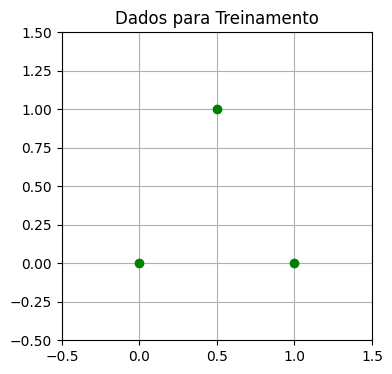

In [66]:
DATA = [(0, 0), (0.5, 1), (1, 0)]

plot = Plot(axis=(-0.5, 1.5, -0.5, 1.5), title="Dados para Treinamento")
PointObject.factory(plot.ax, DATA)
plot.show()

Para aproximar esses dados, a rede neural deve ter 1 entrada e 1 saída, com uma camada escondida (hidden layer) de 2 neurônios.


## Predict

Para a função predict da rede neural teremos que fazer os seguintes cálculos representados na imagem:

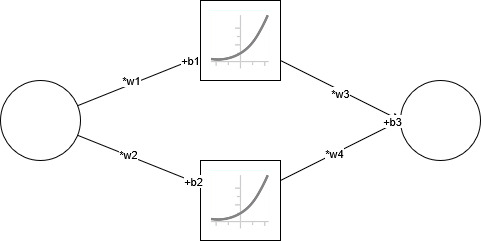

Ou seja:
$$
\text{output} = \phi(\text{input} \cdot w_1 + b_1) \cdot w_3 + \phi(\text{input} \cdot w_2 + b_2) \cdot w_4 + b_3
$$

Como a rede é pequena, podemos apresentar a expressão do predict completa, mas para redes mais complexas essa implementação é inviável.

O processo mais simples para representação e execução da função predict é por camadas, onde cada camada, menos o input, é representado por uma matrix $w_i$ e um vetor $b_i$ que representam os pesos e viéses de cada camada.

### Pesos

Os pesos de cada camada são ordenados em uma matriz, onde cada linha representa cada neurônio (círculo ou quadrado) na camada e cada item uma conexão entre um elemento da camada de entrada e o neurônio (linha).

No caso da imagem mostrada, teremos 2 matrizes com os seguintes valores:

$$
w_{hidden} =
\begin{bmatrix}
w_1 \\
w_2
\end{bmatrix}
\\[2.5mm]
$$

$$
w_{output} =
\begin{bmatrix}
w_3 & w_4
\end{bmatrix}
$$

### Viéses

Os viéses (bias) de cada camada é representado por um vetor $b_i$, onde cada elemento representa o bias de cada neurônio.

Os bias da imagem mostrada são:

$$
b_{hidden} =
\begin{bmatrix}
b_1 \\
b_2
\end{bmatrix}
\\[2.5mm]
$$

$$
b_{output} =
\begin{bmatrix}
b_3
\end{bmatrix}
$$

### Cálculo do predict

Para o cálculo do predict, utilizamos a fórmula:

$$
\text{output}_{i+1} = \phi(w_i \cdot \text{input}_{i} + b_i)
$$

Onde $\text{input}_1$ é o input da rede neural como um vetor, e $\phi$ é a função de ativação (nesse caso softplus).

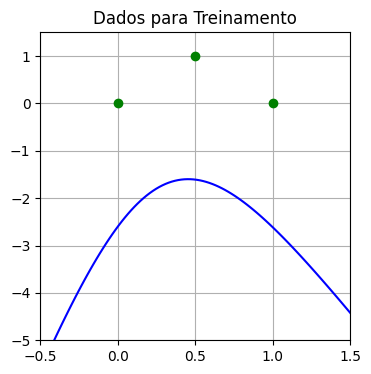

In [70]:
def activation(x):
  return np.log(1 + np.exp(x))

def predict(input):
  input = np.array([input])

  w_hidden = np.array([[3.34], [-3.53]])
  b_hidden = np.array([-1.43, 0.57])

  w_output = np.array([-1.22, -2.30])
  b_output = np.array([0.0])

  hidden_output = activation(w_hidden @ input + b_hidden)
  output = w_output @ hidden_output + b_output

  return output

plot = Plot(axis=(-0.5, 1.5, -5, 1.5), title="Função Predict")
PointObject.factory(plot.ax, DATA)
FunctionObject(plot.ax, predict)
plot.show()

## Otimizando o parâmetro b3

Para otimizar o parâmetro $b_3$ primeiramente precisamos saber o quanto a função está incorreta, para isso utilizamos a soma do erro ao quadrado, assim como mostrado anteriormente:

$$
\text{SSR} = \sum_{i=1}^{n}(\text{Observed} - \text{Predicted})^2
$$

Após isso precisamos saber a influência do parâmetro $b_3$ no $\text{Erro}^2$, para isso utilizaremos a regra da cadeia:

$$
\text{Loss}_{b_3} = \frac{d \text{ SSR}}{d \  b_3} = \frac{d \text{ SSR}}{d \text{ Predict}} \frac{d \text{ Predict}}{d \  b_3} = -2 \cdot \sum_{i=1}^{n}(\text{Observed} - \text{Predicted})
$$

Assim podemos calcular o $\text{Step}$ utilizando o $\text{learning_rate}$:
$$
\text{Step}_{b_3} = \text{Loss}_{b_3} \cdot \text{learning_rate}
$$

E calcular o novo $b_3$:
$$
\text{novo_b3} = b_3 - \text{Step}_{b_3}
$$

## Redes Neurais - Código para otimização do b3

Para implementar a rede neural, temos que implementar os mesmos métodos da regressão linear, mas precisaremos implementar a função de ativação e mudar a implementação dos métodos de `predict`, `descent_gradient` e `learn` para representar as explicações das redes neurais.

In [98]:
class NeuraNetworkB3():
  def __init__(self, b3=0):
    self.hidden_weights = [np.array([[3.34], [-3.53]])]
    self.hidden_biases = [np.array([-1.43, 0.57])]

    self.output_weights = np.array([-1.22, -2.30])
    self.output_biases = np.array([b3])

  def activation(self, x): # softplus activation function
    return np.log(1 + np.exp(x))

  def predict(self, i):
    layers = [np.array([i])]

    for weight, bias in zip(self.hidden_weights, self.hidden_biases):
      layers.append(self.activation(weight @ layers[-1] + bias))

    output = self.output_weights @ layers[-1] + self.output_biases
    layers.append(output)

    return output[0] if len(output) == 1 else output

  def gradient_descent_b3(self, data):
    ssr = 0
    gradient = 0
    for x, y in data:
      predicted = self.predict(x)
      error = y - predicted

      ssr += error**2
      gradient += -2 * error

    return ssr, gradient

  def learn(self, data, learn_rate=0.1, max_reps=100, min_step=0.001, snapshots=False, verbose=False):
    for i in range(max_reps):
      ssr, gradient = self.gradient_descent_b3(data)

      step = learn_rate * gradient
      new_b3 = self.output_biases[0] - step

      if verbose:
        print(f"{'\r' if verbose != 'vv' else '\n'}iteration: {i:<5} b3: {float(self.output_biases[0]):<25} b3_step: {float(step):<25} new b3: {float(new_b3)}", end="")

      if snapshots:
        yield self.output_biases[0], ssr

      self.output_biases = np.array([new_b3])

      if abs(step) <= min_step:
        break

    print()


## Redes Neurais - Exemplo de otimização do b3

In [106]:
neuralNetwork = NeuraNetworkB3(b3=0)

DATA = [(0, 0), (0.5, 1), (1, 0)]

plot = Plot(axis=(-0.5, 1.5, -0.5, 1.5), title="Otimização do b3")
PointObject.factory(plot.ax, DATA)
predict_line = FunctionObject(plot.ax)

def update(frame_data):
  b3, ssr = frame_data
  neuralNetwork.output_biases[0] = b3
  predict_line.function = neuralNetwork.predict

  return plot.updated

learn_data = neuralNetwork.learn(DATA, learn_rate=0.1, max_reps=100, snapshots=True, verbose=True)
plot.animate(update, frames=learn_data, save_count=100, interval=100)

iteration: 9     b3: 2.6085007479744053        b3_step: -0.00041038927313170604   new b3: 2.608911137247537


## Otimização do w3, w4 e b3

